# **Cars 4 You | Machine Learning Project**

### **Import Libraries**

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer
from rapidfuzz import process, fuzz
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression


### **Import Data**

In [50]:
df = pd.read_csv('../data/train.csv')

In [51]:
df[df['fuelType'] == 'Electric']

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
6978,12786,NaN,i3,2015.0,17400,Automatic,29465.0,Electric,0.0,470.8,3.822758,67.0,2.0,0.0
37023,64169,Opel,Ampera,2015.0,12999,Automatic,34461.0,Electric,0.0,235.4,1.400000,83.0,1.0,0.0
52274,21931,Ford,Mondeo,NaN,15500,Automatic,24531.0,Electric,0.0,67.3,2.000000,82.0,4.0,0.0
52579,16306,Ford,Mondeo,2016.0,15975,automatic,9396.0,Electric,0.0,67.3,2.000000,59.0,3.0,0.0


In [52]:
df_models = pd.read_csv('../data/car_models.csv')

---

### **Data Understanding**

In [53]:
df.head()

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
0,69512,VW,Golf,2016.0,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,63.0,4.000000,0.0
1,53000,Toyota,Yaris,2019.0,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1.000000,0.0
2,6366,Audi,Q2,2019.0,24990,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,56.0,4.000000,0.0
3,29021,Ford,FIESTA,2018.0,12500,anual,9102.0,Petrol,145.0,65.700000,1.0,50.0,-2.340306,0.0
4,10062,BMW,2 Series,2019.0,22995,Manual,1000.0,Petrol,145.0,42.800000,1.5,97.0,3.000000,0.0


In [54]:
df.describe(include='all')

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
count,75973.000000,74452,74456,74482.000000,75973.000000,74451,74510.000000,74462,68069.000000,68047.000000,74457.000000,74449.000000,74423.000000,74425.0
unique,NaN,72,735,NaN,NaN,40,NaN,34,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Ford,Focus,NaN,NaN,Manual,NaN,Petrol,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,14808,6353,NaN,NaN,38050,NaN,37995,NaN,NaN,NaN,NaN,NaN,NaN
mean,37986.000000,NaN,NaN,2017.096611,16881.889553,NaN,23004.184088,NaN,120.329078,55.152666,1.660136,64.590667,1.994580,0.0
std,21931.660338,NaN,NaN,2.208704,9736.926322,NaN,22129.788366,NaN,65.521176,16.497837,0.573462,21.021065,1.472981,0.0
min,0.000000,NaN,NaN,1970.000000,450.000000,NaN,-58540.574478,NaN,-91.121630,-43.421768,-0.103493,1.638913,-2.345650,0.0
25%,18993.000000,NaN,NaN,2016.000000,10200.000000,NaN,7423.250000,NaN,125.000000,46.300000,1.200000,47.000000,1.000000,0.0
50%,37986.000000,NaN,NaN,2017.000000,14699.000000,NaN,17300.000000,NaN,145.000000,54.300000,1.600000,65.000000,2.000000,0.0
75%,56979.000000,NaN,NaN,2019.000000,20950.000000,NaN,32427.500000,NaN,145.000000,62.800000,2.000000,82.000000,3.000000,0.0


#### **Data Quality**
- **Price**: we have outliers, since we have a really big jump from the 4th Quartile and the Max value and we have a slightly left skewed distribution
- **Mileage**: we have outliers, since we have a really big jump from the 4th Quartile and the Max value and we have a left skewed distribution, we also have negative values, so we need to handle these values
- **Tax**: we have negative values, we need to investigate why these values are negative and If they make any sense in this context
- **MPG**: We have negative values, we need to handle these values
- **Engine Size**: We have negative values, needing to handle them
- **PaintQuality%**: We have values above 100%, we need to check this cases and see if they make any kind of sense
- **previousOwners**: We have negative and float values, we need to handle this cases as well
- **hasDamage**: Seems like a constant value feature, we need to check if thats the case


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75973 entries, 0 to 75972
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carID           75973 non-null  int64  
 1   Brand           74452 non-null  object 
 2   model           74456 non-null  object 
 3   year            74482 non-null  float64
 4   price           75973 non-null  int64  
 5   transmission    74451 non-null  object 
 6   mileage         74510 non-null  float64
 7   fuelType        74462 non-null  object 
 8   tax             68069 non-null  float64
 9   mpg             68047 non-null  float64
 10  engineSize      74457 non-null  float64
 11  paintQuality%   74449 non-null  float64
 12  previousOwners  74423 non-null  float64
 13  hasDamage       74425 non-null  float64
dtypes: float64(8), int64(2), object(4)
memory usage: 8.1+ MB


In [56]:
# check for duplicates in car ID
df['carID'].nunique() == df.shape[0]

True

In [57]:
# check for duplicate rows
df.duplicated().sum()

np.int64(0)

---

## **Data Preparation**

#### **Checking for constant value features**

In [58]:
# check for constant values features
constant_features = [col for col in df.columns if df[col].nunique() == 1]
print(f'Constant features: {constant_features}')

Constant features: ['hasDamage']


Since hasDamage is a constant feature, we can safely remove it since theres no meaning if its keeped

In [59]:
df= df.drop(columns='hasDamage')

#### **Dealing with missing values**

First, lets check if we have any entries with every feature missing

In [60]:
# create a mask for rows where all columns except 'carID' and 'price' are NaN
mask = df.drop(columns=['carID', 'price']).isna().all(axis=1)
df_missing_rows = df[mask]

df_missing_rows.size

0

We don't have any row that is completely null

##### **Let's now check the percentages of missing values for each column**

In [61]:
# check the percentage of missing values for each column
missing_percent = df.isna().mean() * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)
df_missing_percent = pd.DataFrame({'column': missing_percent.index, 'missing_percent': missing_percent.values})
df_missing_percent

,column,missing_percent
0,mpg,10.432654
1,tax,10.403696
2,previousOwners,2.040198
3,paintQuality%,2.005976
4,transmission,2.003343
5,Brand,2.002027
6,model,1.996762
7,engineSize,1.995446
8,fuelType,1.988864
9,year,1.962539


We have some percentage of missing values but nothing too bad.

#### **Fill Missing Values in Numeric Features**

For the numeric features, we will use KNN imputation with the 5 nearest neighbors and just set the weights to 'uniform'.

In [62]:
num_cols = ['year', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners']

In [63]:
# store mean and std
means = df[num_cols].mean()
stds = df[num_cols].std()

# normalize
df_scaled = (df[num_cols] - means) / stds

# impute on scaled data
imputer = KNNImputer(n_neighbors=5, weights="uniform")
df_imputed_scaled = pd.DataFrame(
    imputer.fit_transform(df_scaled),
    columns=num_cols,
    index=df.index
)

# inverse transform
df[num_cols] = df_imputed_scaled * stds + means

#### **Fill Missing Values in Categorical Features**

For the categorical variables we will use a Random Forest Classifier.  
We will train this RFC with the non null entries and use them to predict the null entries.  
We will do this sequentially in this order:  
Brand -> Model -> fuelType -> transmission

Since we believe thats the feature importance order.

In [64]:
def impute_categorical_rfc(df, target_col, ignore_cols=['carID', 'price'], n_estimators=200):
    """
    Impute missing values in a categorical column using a Random Forest Classifier.

    Parameters:
        df (pd.DataFrame): The dataframe containing missing values.
        target_col (str): Column to impute.
        ignore_cols (list): Columns to exclude from predictors.
        n_estimators (int): Number of trees for the Random Forest.

    Returns:
        pd.DataFrame: DataFrame with imputed column.
    """
    #split into rows with and without missing target
    df_notnull = df[df[target_col].notnull()]
    df_null = df[df[target_col].isnull()]

    #print(df_null.head())
    
    # predictors: list of all columns except target and ignored ones
    predictors = df.columns.drop([target_col] + ignore_cols)
    #print(predictors)
    
    #encode predictors, creates a column for every value of the target col and sets True/False for each row
    X_train = pd.get_dummies(df_notnull[predictors], drop_first=True)
    print(X_train)
    y_train = df_notnull[target_col]
    
    # train RFC
    rfc = RandomForestClassifier(n_estimators=n_estimators, random_state=42, n_jobs=-1)
    rfc.fit(X_train, y_train)
    
    # predict missing
    if not df_null.empty:
        X_null = pd.get_dummies(df_null[predictors], drop_first=True)
        # we need to reindex the columns of X_null so we have the same columns as X_train
        # if therese a column in X_train that is not in X_null, we fill it with 0
        # if theres a column in X_null that is not in X_train, it will random guess
        X_null = X_null.reindex(columns=X_train.columns, fill_value=0)
        
        df.loc[df[target_col].isnull(), target_col] = rfc.predict(X_null)
    
    print(f"Imputed '{target_col}' using Random Forest with {len(X_train)} training rows.")
    return df

In [65]:
'''cat_cols = ['Brand', 'model', 'fuelType', 'transmission']

for col in cat_cols:
    df = impute_categorical_rfc(df, col)'''


"cat_cols = ['Brand', 'model', 'fuelType', 'transmission']\n\nfor col in cat_cols:\n    df = impute_categorical_rfc(df, col)"

In [66]:
# save the filled dataframe to a csv file
#df.to_csv('../data/filled_cars.csv', index=False)

In [67]:
df = pd.read_csv('../data/filled_cars.csv')

---

### **Data Consistency**

**fixing brand and model typos**

In [68]:
# normalize strings: strip, lower
def clean_text(s):
    if pd.isna(s):
        return ''
    return str(s).strip().lower()

# normalize
df['brand_clean'] = df['Brand'].apply(clean_text)
df['model_clean'] = df['model'].apply(clean_text)
df_models['brand_clean'] = df_models['brand'].apply(clean_text)
df_models['model_clean'] = df_models['model'].apply(clean_text)
#print('Unique values for brand', df_models['brand_clean'].unique())


# --- fix models ---
def correct_model(row, df_models):
    model = row['model_clean']
    brand = row['brand_clean']
    
    if ((df_models['brand_clean'] == brand) & (df_models['model_clean'] == model)).any():
        return model
    
    if brand in df_models['brand_clean'].values:
        possible_models = df_models[df_models['brand_clean']==brand]['model_clean'].tolist()
        matched_model, score = safe_extract_one(model, possible_models, scorer=fuzz.ratio)
        return matched_model if score >= 40 else model
    
    possible_models = df_models['model_clean'].tolist()
    matched_model, score = safe_extract_one(model, possible_models, scorer=fuzz.ratio)
    return matched_model if score >= 40 else model

# --- fix brands ---
def correct_brand(row, df_models):
    brand = row['brand_clean']
    model = row['model_fixed']
    
    if brand in df_models['brand_clean'].values:
        return brand
    if model == 'unknown':
        return brand
    
    possible_brands = df_models[df_models['model_clean']==model]['brand_clean'].unique()
    #print("possible brands",possible_brands)
    if len(possible_brands) > 0:
        return possible_brands[0]
    
    all_brands = df_models['brand_clean'].unique()
    matched_brand, score = safe_extract_one(brand, all_brands, scorer=fuzz.token_sort_ratio)
    return matched_brand if score >= 40 else brand

# standard values in model
def standardize_model(s):
    if pd.isna(s):
        return ''
    s = str(s).lower().strip()
    s = s.replace('-', ' ')
    s = ' '.join(s.split())
    return s

def safe_extract_one(query, choices, scorer):
    result = process.extractOne(query, choices, scorer=scorer)
    if result is None:
        return None, 0
    # Algumas versões retornam 2 valores, outras 3
    if len(result) == 2:
        match, score = result
    elif len(result) == 3:
        match, score, _ = result
    else:
        match, score = result[0], result[1]
    return match, score



# standardize
df_models['model_clean'] = df_models['model'].apply(standardize_model)
df['model_clean'] = df['model'].apply(standardize_model)

# apply fix functions
df['model_fixed'] = df.apply(correct_model, axis=1, df_models=df_models)
df['brand_fixed'] = df.apply(correct_brand, axis=1, df_models=df_models)

# final resutl
df[['Brand', 'model', 'brand_fixed', 'model_fixed']]


# drop columns brand clean, model_clean, brand, model
df.drop(columns=['brand_clean', 'model_clean', 'Brand', 'model'], inplace= True)

df = df.rename(columns={'brand_fixed': 'brand', 'model_fixed': 'model'})

**fixing fuel type and transmission typos**

In [69]:
# Canonical values of fuel_type and transmission
canonical_fuels = ['petrol', 'diesel', 'hybrid', 'electric', 'other']
canonical_transmissions = ['manual', 'automatic', 'semi-auto', 'other']

# Normalize column strings
df['fuel_type_clean'] = (df['fuelType']
    .astype(str)
    .str.strip()
    .str.lower()
)
df['transmission_clean'] = (df['transmission']
    .astype(str)
    .str.strip()
    .str.lower()
)

# Correcting typos in the columns
def fuzzy_match_column(series, canonical_values, score_cutoff=85, default='other'):
    """
    Fuzzy-matches each value in a pandas Series to a list of canonical values.
    Example:
        fuzzy_match_column(df['fuel_type_clean'], ['petrol', 'diesel', 'electric'])
    """
    def match_one(value):


        # exact match
        if value in canonical_values:
            return value

        # fuzzy match
        match = process.extractOne(value, canonical_values, scorer=fuzz.token_sort_ratio)
        if match is None:
            return "unknown"

        best_choice, score, _ = match
        return best_choice if score >= score_cutoff else default

    return series.apply(match_one)


# apply fix functions
df['fuel_type_fixed'] = fuzzy_match_column(df['fuel_type_clean'], canonical_fuels)
df['transmission_fixed'] = fuzzy_match_column(df['transmission_clean'], canonical_transmissions)


# final result
df[['fuelType', 'fuel_type_clean', 'fuel_type_fixed',
    'transmission', 'transmission_clean', 'transmission_fixed']].head(10)


# drop and rename
df.drop(columns= ['fuelType', 'fuel_type_clean', 'transmission','transmission_clean'], inplace= True)

df = df.rename(columns={'fuel_type_fixed': 'fuel_type', 'transmission_fixed': 'transmission'})

### **Duplicates**

First thing first, lets check if we have duplicate ids

In [70]:
df['carID'][df['carID'].duplicated()]

Series([], Name: carID, dtype: int64)

AS we see, theres no duplicated ids

In [71]:
df[df.duplicated(keep=False)]

,carID,year,price,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,model,brand,fuel_type,transmission


No duplicated rows as well

### **Fix Column Names**

In [72]:
# change order of columns
df = df[['carID','brand', 'model', 'year', 'transmission', 'mileage', 'fuel_type', 'tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners', 'price']]

In [73]:
# rename column cardid to car_id and brand fixed to brand
df = df.rename(columns={'carID': 'car_id', 'engineSize': 'engine_size', 'paintQuality%': 'paint_quality', 'previousOwners': 'previous_owners'})

In [74]:
df.head()

,car_id,brand,model,year,transmission,mileage,fuel_type,tax,mpg,engine_size,paint_quality,previous_owners,price
0,69512,volkswagen,golf,2016.0,semi-auto,28421.0,petrol,102.333851,11.417268,2.0,63.0,4.000000,22290
1,53000,toyota,yaris,2019.0,manual,4589.0,petrol,145.000000,47.900000,1.5,50.0,1.000000,13790
2,6366,audi,q3,2019.0,semi-auto,3624.0,petrol,145.000000,40.900000,1.5,56.0,4.000000,24990
3,29021,ford,fiesta,2018.0,manual,9102.0,petrol,145.000000,65.700000,1.0,50.0,-2.340306,12500
4,10062,bmw,2 series,2019.0,manual,1000.0,petrol,145.000000,42.800000,1.5,97.0,3.000000,22995


In [75]:
#Negative Values

In [76]:
columns_negative= ["previous_owners","mileage","mpg","engine_size","tax"]

# Apply abs function to each column in columns_negative
for col in columns_negative:
    df[col] = df[col].abs()

In [77]:
df[['mileage','paint_quality','year','previous_owners']] = (
    df[['mileage','paint_quality','year','previous_owners']]
    .round()
    .astype('Int64')   # allows missing values
)

In [78]:
df[['tax', 'mpg']] = df[['tax', 'mpg']].round(2)


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75973 entries, 0 to 75972
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   car_id           75973 non-null  int64  
 1   brand            75973 non-null  object 
 2   model            75973 non-null  object 
 3   year             75973 non-null  Int64  
 4   transmission     75973 non-null  object 
 5   mileage          75973 non-null  Int64  
 6   fuel_type        75973 non-null  object 
 7   tax              75973 non-null  float64
 8   mpg              75973 non-null  float64
 9   engine_size      75973 non-null  float64
 10  paint_quality    75973 non-null  Int64  
 11  previous_owners  75973 non-null  Int64  
 12  price            75973 non-null  int64  
dtypes: Int64(4), float64(3), int64(2), object(4)
memory usage: 7.8+ MB


In [80]:
#df.to_csv('output.csv', index=False)

In [81]:
# Filter for rows where fuel_type is 'Electric'
df[df['fuel_type'] == 'electric']

,car_id,brand,model,year,transmission,mileage,fuel_type,tax,mpg,engine_size,paint_quality,previous_owners,price
6978,12786,mercedes,i3,2015,automatic,29465,electric,0.0,470.8,3.822758,67,2,17400
37023,64169,opel,meriva,2015,automatic,34461,electric,0.0,235.4,1.400000,83,1,12999
52274,21931,ford,bronco,2017,automatic,24531,electric,0.0,67.3,2.000000,82,4,15500
52579,16306,ford,bronco,2016,automatic,9396,electric,0.0,67.3,2.000000,59,3,15975


In [82]:
df[df['tax'] == 0]

,car_id,brand,model,year,transmission,mileage,fuel_type,tax,mpg,engine_size,paint_quality,previous_owners,price
30,55065,toyota,c hr,2017,automatic,59000,hybrid,0.0,74.3,1.8,95,2,15490
37,64396,opel,astra,2015,manual,37953,diesel,0.0,78.5,1.6,61,2,6995
67,54783,toyota,yaris,2014,automatic,34528,hybrid,0.0,80.7,1.5,79,1,10490
72,47148,skoda,rapid,2016,manual,33395,diesel,0.0,67.3,1.6,68,3,7991
76,19051,ford,fiesta,2013,manual,43181,petrol,0.0,65.7,1.0,88,0,6500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
75865,54268,toyota,camry,2017,manual,10266,petrol,0.0,69.0,1.0,51,0,6620
75871,52992,toyota,camry,2016,manual,20680,petrol,0.0,69.0,1.0,66,2,8550
75880,30535,ford,fiesta,2016,manual,46000,petrol,0.0,65.7,1.0,88,2,8990
75948,65725,volkswagen,golf,2016,automatic,30000,other,0.0,188.3,1.4,53,1,18500


In [83]:
print(df['fuel_type'].unique())

['petrol' 'diesel' 'hybrid' 'other' 'electric']


In [84]:
# Check how many rows have engine_size = 0
zero_engine_cars = df[df['engine_size'] == 0]

# Count how many unique car_ids have engine_size = 0
count_zero_engine = zero_engine_cars['car_id'].nunique()

print(f"Number of cars with engine_size = 0: {count_zero_engine}")

Number of cars with engine_size = 0: 180


In [85]:
df[(df['engine_size'] == 0)]

,car_id,brand,model,year,transmission,mileage,fuel_type,tax,mpg,engine_size,paint_quality,previous_owners,price
64,30317,ford,focus,2019,manual,10000,petrol,145.00,47.90,0.0,61,3,9999
759,21935,ford,ka,2018,manual,17000,petrol,145.00,57.70,0.0,51,0,8444
1039,9518,bmw,2 series,2015,automatic,32882,diesel,125.00,60.10,0.0,55,0,14700
1057,32528,hyundai,tucson,2016,manual,27311,diesel,30.00,61.70,0.0,73,1,13800
1519,33804,hyundai,tucson,2019,manual,22397,petrol,150.00,34.90,0.0,54,2,15000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
74469,26630,ford,fiesta,2018,manual,18000,petrol,145.00,65.70,0.0,82,0,11463
75168,20128,ford,focus,2018,manual,19000,petrol,107.84,59.04,0.0,48,2,18389
75401,47605,skoda,fabia,2018,manual,10720,petrol,150.00,64.20,0.0,84,4,11500
75405,33307,hyundai,i30,2018,manual,12948,petrol,145.00,60.10,0.0,46,2,8500


In [86]:
# Filter rows where engine_size = 0
zero_engine_cars = df[df['engine_size'] == 0]

# Count how many unique car_ids have engine_size = 0
count_zero_engine = zero_engine_cars['car_id'].nunique()

# Print the result
print(f"Number of cars with engine_size = 0: {count_zero_engine}\n")

# Print the list of car_ids
print("List of car_ids with engine_size = 0:")
print(zero_engine_cars.head(10))  # shows first 10 rows


Number of cars with engine_size = 0: 180

List of car_ids with engine_size = 0:
      car_id    brand     model  year transmission  mileage fuel_type    tax  \
64     30317     ford     focus  2019       manual    10000    petrol  145.0   
759    21935     ford        ka  2018       manual    17000    petrol  145.0   
1039    9518      bmw  2 series  2015    automatic    32882    diesel  125.0   
1057   32528  hyundai    tucson  2016       manual    27311    diesel   30.0   
1519   33804  hyundai    tucson  2019       manual    22397    petrol  150.0   
1547   29914     ford     focus  2018       manual    11000    petrol  143.0   
1857   32542  hyundai       i30  2018       manual    30012    petrol  145.0   
2468   62456     opel  insignia  2017       manual    30740    diesel  150.0   
3326    5718     audi        q3  2020    automatic     1500    petrol  145.0   
3445     839     audi        a3  2016       manual    30590    petrol   30.0   

        mpg  engine_size  paint_quality

---

### **Bivariate analysis**

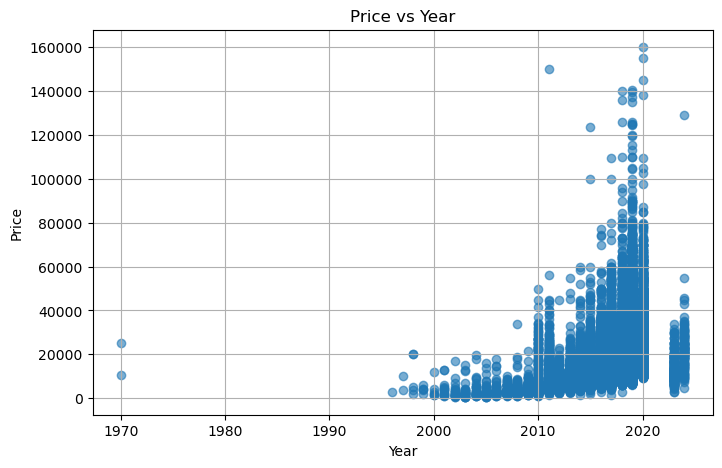

In [87]:
plt.figure(figsize=(8,5))
plt.scatter(df['year'], df['price'], alpha=0.6)
plt.title('Price vs Year')
plt.xlabel('Year')
plt.ylabel('Price')
plt.grid(True)
plt.show()

#### **Price vs year**
- newer cars (2016–2024) have much higher prices and wider spread, wwhich's normal
- older cars (before 2005) - a few have prices above £20,000–£40,000, but most of them are concentrated at price under £20,000
- **Drop cars with year < 1990 as this value doesn't make sense**

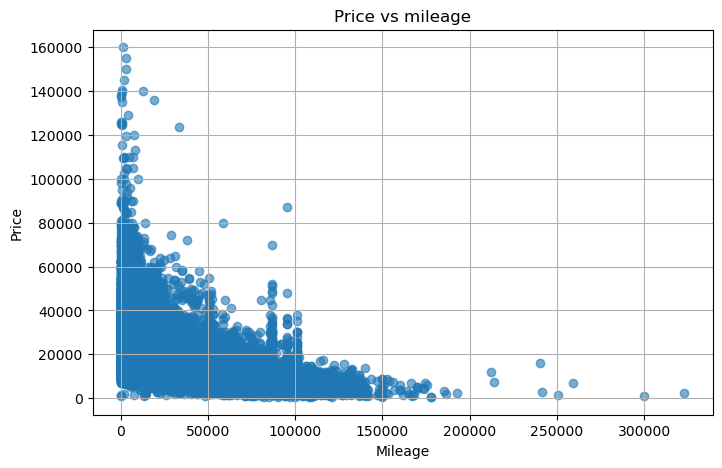

In [88]:
plt.figure(figsize=(8,5))
plt.scatter(df['mileage'], df['price'], alpha=0.6)
plt.title('Price vs mileage')
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [89]:
# Show cars with very high mileage 
print("\nCars with mileage > 200000 and price < 30000:")
display(df[(df["mileage"] > 200000) & (df["price"] < 30000)])



Cars with mileage > 200000 and price < 30000:


,car_id,brand,model,year,transmission,mileage,fuel_type,tax,mpg,engine_size,paint_quality,previous_owners,price
4840,48382,skoda,octavia,2010,manual,300000,diesel,125.0,57.6,1.9,79,2,1190
6435,39946,mercedes,a class,2016,automatic,240494,diesel,20.0,68.9,2.1,81,4,16249
6658,4692,audi,a6,2008,manual,323000,diesel,200.0,44.1,2.0,74,1,2490
33429,9978,bmw,x5,2012,automatic,214000,diesel,300.0,37.7,3.0,68,1,7250
33484,48912,skoda,octavia,2018,automatic,241565,diesel,185.0,47.9,1.9,33,4,2750
41953,74387,volkswagen,caravelle,2012,automatic,212000,diesel,325.0,34.4,2.0,42,2,11995
45843,48042,skoda,octavia,2010,manual,250650,diesel,125.0,57.6,1.9,62,1,1485
55413,45370,mercedes,g class,2010,automatic,259000,diesel,540.0,30.7,3.0,54,1,6949


In [90]:
# Show cars that are too expensive for low mileage (possible luxury or data error)
print("Cars with price > 100000 and mileage < 50000:")
display(df[(df["price"] < 20000) & (df["mileage"] < 20000)])


Cars with price > 100000 and mileage < 50000:


,car_id,brand,model,year,transmission,mileage,fuel_type,tax,mpg,engine_size,paint_quality,previous_owners,price
1,53000,toyota,yaris,2019,manual,4589,petrol,145.0,47.90,1.50,50,1,13790
3,29021,ford,fiesta,2018,manual,9102,petrol,145.0,65.70,1.00,50,2,12500
9,23348,ford,focus,2019,manual,10700,petrol,150.0,60.10,1.00,35,1,15300
13,48622,skoda,fabia,2019,automatic,14378,petrol,145.0,60.10,1.36,59,1,13295
14,65892,volkswagen,golf,2017,manual,9500,petrol,150.0,54.30,1.40,69,2,13990
...,...,...,...,...,...,...,...,...,...,...,...,...,...
75965,16023,ford,ecosport,2017,manual,13613,petrol,125.0,88.32,1.00,57,3,10498
75966,60263,opel,crossland x,2018,manual,1800,petrol,150.0,57.70,1.20,69,0,13995
75968,37194,mercedes,c class,2015,manual,14480,petrol,125.0,53.30,2.00,78,0,13498
75970,54886,toyota,camry,2017,automatic,11304,petrol,145.0,67.00,1.00,57,3,8399


#### **Price vs mileage**
- negative correlation - higher mileage = lower price.
- A few low-mileage cars with very low prices  - quite reasonable prices for the models, high prices - better and newer cars
- A few high-mileage cars (>200,000–250,000 km) still make sense as price is reasonably low for them


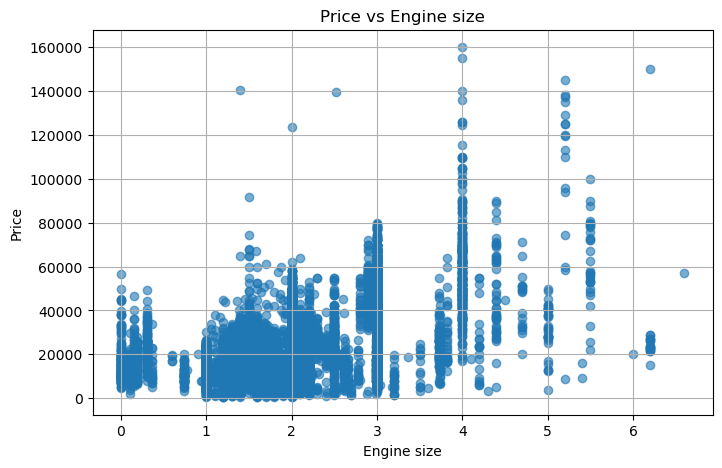

In [91]:
plt.figure(figsize=(8,5))
plt.scatter(df['engine_size'], df['price'], alpha=0.6)
plt.title('Price vs Engine size')
plt.xlabel('Engine size')
plt.ylabel('Price')
plt.grid(True)
plt.show()

- After aanalyzing the graph we decided to print the values that look unrealistic to see if these are luxury cars and the values are  real or it's a mistake in entries

In [92]:
# Show cars that are too expensive for small engines
print("Cars with price > 120000 and engine_size < 3.0:")
display(df[(df["price"] > 120000) & (df["engine_size"] < 3.0)])

# Show cars that are too cheap for big engines
print("\nCars with engine_size > 5.0 and price < 25000:")
display(df[(df["engine_size"] > 5.0) & (df["price"] < 25000)])


Cars with price > 120000 and engine_size < 3.0:


,car_id,brand,model,year,transmission,mileage,fuel_type,tax,mpg,engine_size,paint_quality,previous_owners,price
15364,41265,mercedes,a class,2019,semi-auto,1000,petrol,145.0,22.1,2.52,37,4,139559
34018,43994,mercedes,a class,2019,semi-auto,785,petrol,150.0,22.1,1.40,64,0,140319
44022,13374,bmw,2 series,2015,semi-auto,33419,diesel,20.0,68.9,2.00,42,3,123456



Cars with engine_size > 5.0 and price < 25000:


,car_id,brand,model,year,transmission,mileage,fuel_type,tax,mpg,engine_size,paint_quality,previous_owners,price
4049,38980,mercedes,c class,2013,semi-auto,43442,petrol,280.00,41.52,6.2,76,0,23000
5047,46372,mercedes,c class,2013,semi-auto,49964,petrol,397.21,23.00,6.2,78,3,22995
14216,35612,mercedes,c class,2013,automatic,52396,petrol,570.00,23.50,6.2,44,2,23990
20432,35538,mercedes,c class,2010,semi-auto,49964,petrol,326.03,32.62,6.2,58,3,22995
20916,44937,mercedes,c class,2013,automatic,41866,petrol,570.00,23.50,6.2,80,0,21999
23239,3167,audi,a6,2006,automatic,98000,petrol,570.00,21.10,5.2,93,0,8750
24327,46536,mercedes,c class,2013,automatic,44000,petrol,225.00,39.18,6.2,88,2,23990
29612,45353,mercedes,cl class,2002,automatic,77000,petrol,325.00,21.10,5.4,42,2,8995
39475,37825,mercedes,e class,2008,semi-auto,55000,petrol,570.00,19.80,6.2,70,1,14995
41101,40094,mercedes,c class,2013,automatic,39000,petrol,392.00,29.02,6.2,89,1,22948


#### **Price vs Engine Size**
- As we can see for cars with engine size <3 price is unreasonably high, as a normal price for these cars is around 20-30000
- Also cars with too high engine size aren't within normal range as normally cars of these models have 2-3L, but the price is quite normal
- **So, we will consider both of these categories as outliers as the values don't make sense ina  real world**

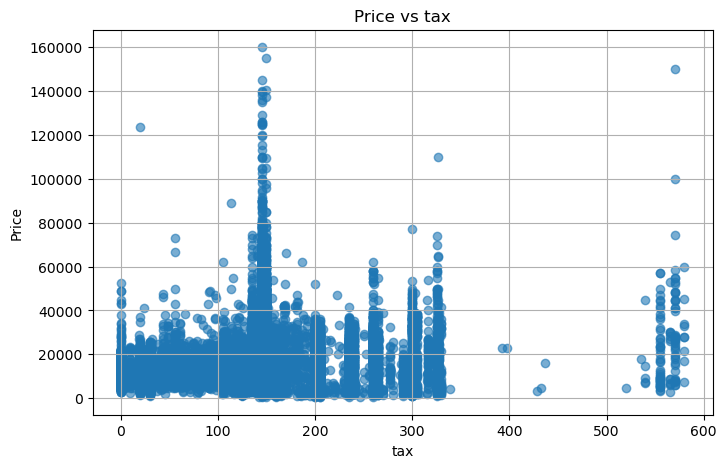

In [93]:
plt.figure(figsize=(8,5))
plt.scatter(df['tax'], df['price'], alpha=0.6)
plt.title('Price vs tax')
plt.xlabel('tax')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [94]:
# Cars with tax between 370 and 460 and price smaller than 60,000
print("Cars with tax between 370 and 460 and price smaller than 60,000:")
display(df[(df["tax"].between(370, 460)) & (df["price"] < 60000)])

# Cars with tax smaller than 100 and price higher than 120,000
print("\nCars with tax smaller than 100 and price higher than 120,000:")
display(df[(df["tax"] < 100) & (df["price"] > 120000)])

# Cars with tax between 300 and 400 and price higher than 100,000
print("\nCars with tax between 300 and 400 and price higher than 100,000:")
display(df[(df["tax"].between(300, 400)) & (df["price"] > 100000)])

# Cars with tax between 500 and 600 and price higher than 80,000
print("\nCars with tax between 500 and 600 and price higher than 80,000:")
display(df[(df["tax"].between(500, 600)) & (df["price"] > 80000)])


Cars with tax between 370 and 460 and price smaller than 60,000:


,car_id,brand,model,year,transmission,mileage,fuel_type,tax,mpg,engine_size,paint_quality,previous_owners,price
5047,46372,mercedes,c class,2013,semi-auto,49964,petrol,397.21,23.00,6.200000,78,3,22995
29346,40302,mercedes,c class,2006,automatic,86000,petrol,428.00,33.68,3.500000,55,2,3200
41101,40094,mercedes,c class,2013,automatic,39000,petrol,392.00,29.02,6.200000,89,1,22948
60730,70253,volkswagen,golf,2009,automatic,82545,petrol,432.00,47.10,2.985793,42,6,4795
72352,35098,mercedes,c class,2005,automatic,73000,petrol,437.00,28.56,5.400000,68,2,15990



Cars with tax smaller than 100 and price higher than 120,000:


,car_id,brand,model,year,transmission,mileage,fuel_type,tax,mpg,engine_size,paint_quality,previous_owners,price
44022,13374,bmw,2 series,2015,semi-auto,33419,diesel,20.0,68.9,2.0,42,3,123456



Cars with tax between 300 and 400 and price higher than 100,000:


,car_id,brand,model,year,transmission,mileage,fuel_type,tax,mpg,engine_size,paint_quality,previous_owners,price
72299,44942,mercedes,s class,2019,semi-auto,4688,petrol,326.03,31.7,4.0,42,1,109995



Cars with tax between 500 and 600 and price higher than 80,000:


,car_id,brand,model,year,transmission,mileage,fuel_type,tax,mpg,engine_size,paint_quality,previous_owners,price
29297,35970,mercedes,g class,2015,semi-auto,10000,petrol,570.0,20.5,5.5,74,3,99850
34690,46012,mercedes,sl class,2011,automatic,3000,petrol,570.0,21.4,6.2,78,4,149948


#### **Price vs tax**
- We considered values of tax > 300 as outliers because they represent rare, high-performance or luxury vehicles that are not representative of the general car market and could skew model predictions.
- We kept values under 100 since they likely correspond to electric or low-emission cars with valid low tax rates, not errors.

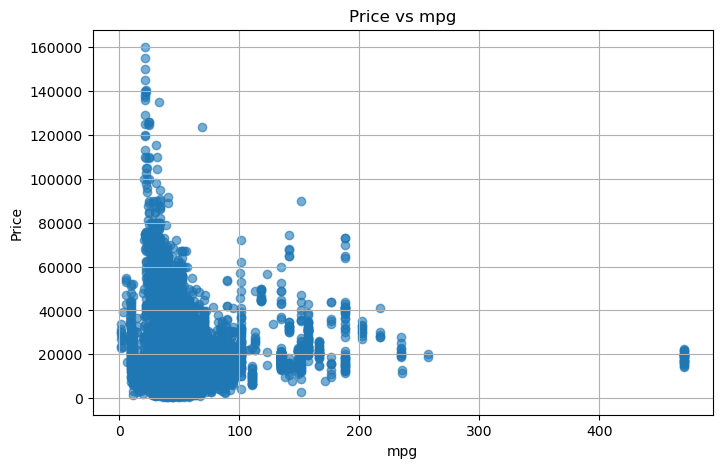

In [95]:
plt.figure(figsize=(8,5))
plt.scatter(df['mpg'], df['price'], alpha=0.6)
plt.title('Price vs mpg')
plt.xlabel('mpg')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [96]:
# --- Check strange combinations between price and mpg ---

print("Cars with very high price but extremely low mpg:")
display(df[(df["price"] > 120000) & (df["mpg"] < 50)])

print("\nCars with extremely high mpg but very low price:")
display(df[(df["mpg"] > 300) & (df["price"] < 25000)])


Cars with very high price but extremely low mpg:


,car_id,brand,model,year,transmission,mileage,fuel_type,tax,mpg,engine_size,paint_quality,previous_owners,price
2824,5953,audi,r8,2019,semi-auto,10,petrol,150.0,21.4,5.20,70,1,137500
6147,35988,mercedes,g class,2018,semi-auto,13046,petrol,145.0,21.4,4.00,36,2,139995
11412,7208,audi,r8,2020,semi-auto,70,petrol,145.0,21.1,5.20,58,0,137995
15364,41265,mercedes,a class,2019,semi-auto,1000,petrol,145.0,22.1,2.52,37,4,139559
26520,35363,mercedes,a class,2019,semi-auto,880,petrol,145.0,24.8,4.00,41,4,124366
33066,36548,mercedes,a class,2019,automatic,250,petrol,145.0,24.6,4.00,37,1,126000
34018,43994,mercedes,a class,2019,semi-auto,785,petrol,150.0,22.1,1.40,64,0,140319
34690,46012,mercedes,sl class,2011,automatic,3000,petrol,570.0,21.4,6.20,78,4,149948
35716,36614,mercedes,g class,2018,semi-auto,19000,petrol,145.0,21.4,4.00,67,1,135771
50309,2424,audi,r8,2019,automatic,100,petrol,145.0,24.1,5.20,62,2,125000



Cars with extremely high mpg but very low price:


,car_id,brand,model,year,transmission,mileage,fuel_type,tax,mpg,engine_size,paint_quality,previous_owners,price
4101,13075,bmw,i3,2015,automatic,33931,hybrid,0.0,470.8,0.000000,31,4,15498
5278,12640,bmw,i3,2017,automatic,23956,other,135.0,470.8,0.600000,53,1,19500
6978,12786,mercedes,i3,2015,automatic,29465,electric,0.0,470.8,3.822758,67,2,17400
18261,8993,bmw,i3,2016,automatic,9990,hybrid,0.0,470.8,0.000000,44,0,18999
18710,12853,bmw,i3,2017,automatic,10839,hybrid,0.0,470.8,0.000000,31,4,21898
21445,12090,bmw,i3,2016,automatic,8421,hybrid,0.0,470.8,0.000000,31,4,19490
24975,13378,bmw,i3,2015,automatic,9886,hybrid,0.0,470.8,0.000000,44,0,17481
29581,12269,bmw,i3,2017,automatic,26965,hybrid,140.0,470.8,0.000000,81,3,19980
33383,10695,bmw,i3,2017,automatic,23883,hybrid,135.0,470.8,0.000000,54,1,21494
33829,11532,bmw,i3,2016,automatic,35446,hybrid,0.0,470.8,0.000000,59,3,16500


#### **Price vs mpg**
- Cars with very high price but extremely low mpg: mercedes	a class and sl class have unreasonably high price, and audi r8 and mercedes a class have realistic price and mpg level

- Cars with extremely high mpg but very low price are all from the same car model, so we will keep it as it can be unique for car model

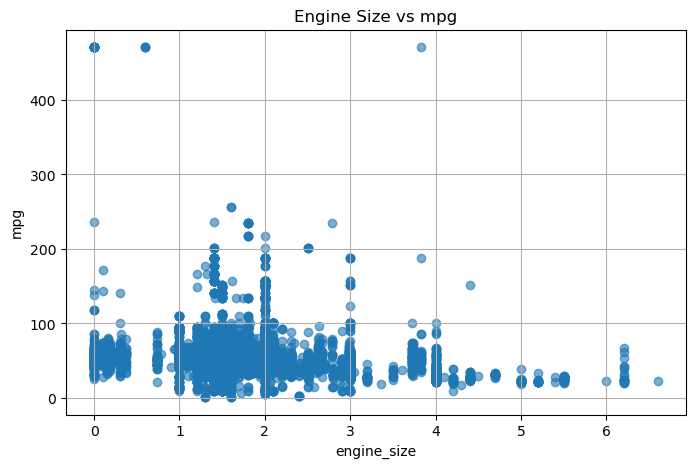

In [97]:
plt.figure(figsize=(8,5))
plt.scatter(df['engine_size'], df['mpg'], alpha=0.6)
plt.title('Engine Size vs mpg')
plt.xlabel('engine_size')
plt.ylabel('mpg')
plt.grid(True)
plt.show()

In [98]:
print("\nCars with extremely high mpg but very small engine size:")
display(df[(df["mpg"] > 400) & (df["engine_size"] < 4)])


Cars with extremely high mpg but very small engine size:


,car_id,brand,model,year,transmission,mileage,fuel_type,tax,mpg,engine_size,paint_quality,previous_owners,price
4101,13075,bmw,i3,2015,automatic,33931,hybrid,0.0,470.8,0.000000,31,4,15498
5278,12640,bmw,i3,2017,automatic,23956,other,135.0,470.8,0.600000,53,1,19500
6978,12786,mercedes,i3,2015,automatic,29465,electric,0.0,470.8,3.822758,67,2,17400
18261,8993,bmw,i3,2016,automatic,9990,hybrid,0.0,470.8,0.000000,44,0,18999
18710,12853,bmw,i3,2017,automatic,10839,hybrid,0.0,470.8,0.000000,31,4,21898
21445,12090,bmw,i3,2016,automatic,8421,hybrid,0.0,470.8,0.000000,31,4,19490
24975,13378,bmw,i3,2015,automatic,9886,hybrid,0.0,470.8,0.000000,44,0,17481
29581,12269,bmw,i3,2017,automatic,26965,hybrid,140.0,470.8,0.000000,81,3,19980
33383,10695,bmw,i3,2017,automatic,23883,hybrid,135.0,470.8,0.000000,54,1,21494
33829,11532,bmw,i3,2016,automatic,35446,hybrid,0.0,470.8,0.000000,59,3,16500


#### **Engine Size vs mpg**
- Cars with extremely high mpg but very small engine size are focused in the same brand of the car, we will consider it a specification of the car

In [99]:
print("Cars with very large engine size but extremely low mpg:")
display(df[(df["engine_size"] > 5) & (df["mpg"] < 25)])

Cars with very large engine size but extremely low mpg:


,car_id,brand,model,year,transmission,mileage,fuel_type,tax,mpg,engine_size,paint_quality,previous_owners,price
2824,5953,audi,r8,2019,semi-auto,10,petrol,150.00,21.40,5.2,70,1,137500
5047,46372,mercedes,c class,2013,semi-auto,49964,petrol,397.21,23.00,6.2,78,3,22995
5630,9197,bmw,7 series,2017,automatic,11297,petrol,145.00,22.10,6.6,68,1,57000
6123,5324,audi,r8,2019,automatic,3000,petrol,145.00,21.40,5.2,47,2,119450
6913,44315,mercedes,gl class,2019,automatic,3574,petrol,145.00,23.70,5.5,68,3,71899
7088,40609,mercedes,gl class,2018,automatic,7390,petrol,150.00,23.00,5.5,56,4,72950
10007,43941,mercedes,gl class,2016,semi-auto,19466,petrol,570.00,23.90,5.5,77,3,48480
10144,2743,audi,r8,2018,semi-auto,3800,petrol,145.00,23.00,5.2,42,3,93950
11412,7208,audi,r8,2020,semi-auto,70,petrol,145.00,21.10,5.2,58,0,137995
11462,40976,mercedes,gl class,2019,semi-auto,9,petrol,145.00,23.70,5.5,59,1,75995


#### **Engine Size vs mpg**
- Cars with very large engine size but extremely low mpg we considered as outliers and decided to drop

---

In [100]:
# Check how many rows have engine_size = 0
zero_engine_cars = df[df['engine_size'] == 0]

# Count how many unique car_ids have engine_size = 0
count_zero_engine = zero_engine_cars['car_id'].nunique()

print(f"Number of cars with engine_size = 0: {count_zero_engine}")

Number of cars with engine_size = 0: 180


### **Outliers**

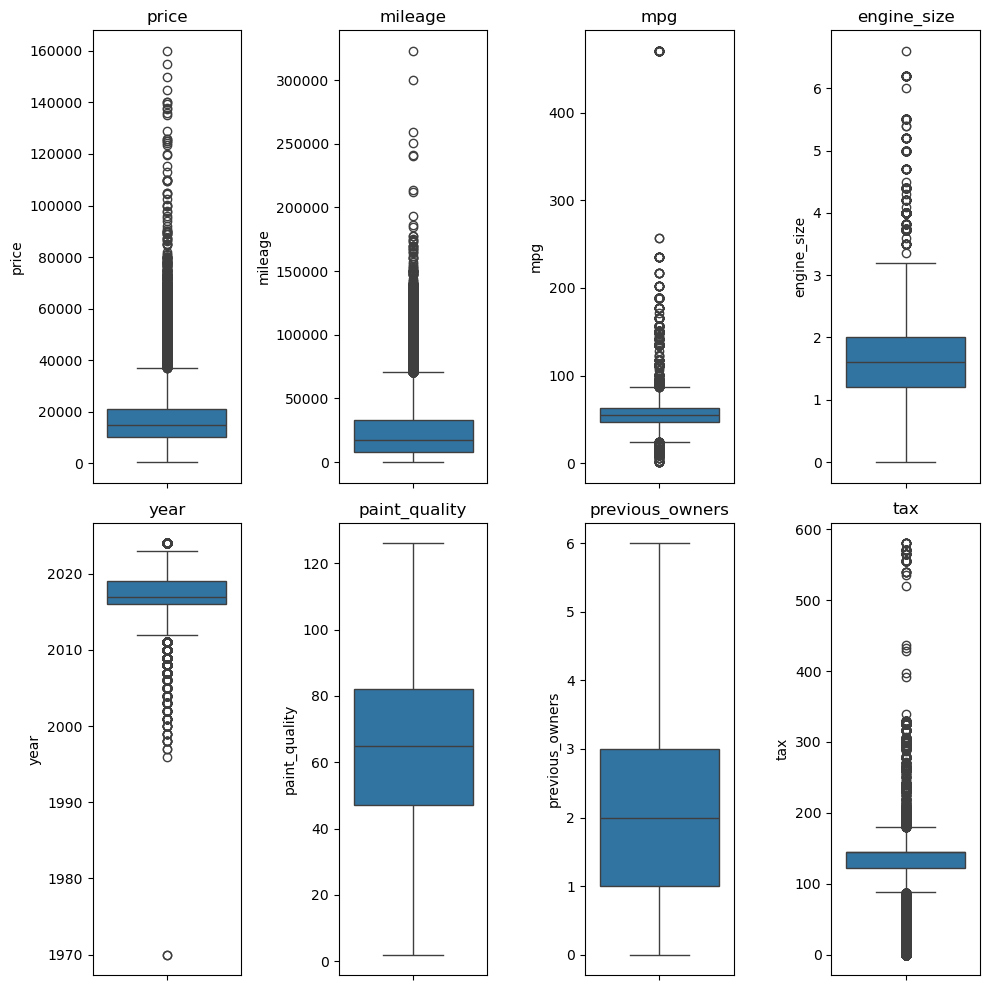

In [101]:
fig, axes = plt.subplots(2, 4, figsize=(10, 10))
axes = axes.flatten()  # makes it a 1D array of length 6

sns.boxplot(df["price"], ax=axes[0])
axes[0].set_title("price")

sns.boxplot(df["mileage"], ax=axes[1])
axes[1].set_title("mileage")

sns.boxplot(df["mpg"], ax=axes[2])
axes[2].set_title("mpg")

sns.boxplot(df["engine_size"], ax=axes[3])
axes[3].set_title("engine_size")

sns.boxplot(df["year"], ax=axes[4])
axes[4].set_title("year")

sns.boxplot(df["paint_quality"], ax=axes[5])
axes[5].set_title("paint_quality")

sns.boxplot(df["previous_owners"], ax=axes[6])
axes[6].set_title("previous_owners")

sns.boxplot(df["tax"], ax=axes[7])
axes[7].set_title("tax")

plt.tight_layout()
plt.show()

1️⃣ price 

Observations: Most cars are clustered below ~40,000£, but there are numerous outliers above 50,000£, some exceeding 160,000£.
Interpretation: The dataset includes luxury or rare cars that are not typical — a right-skewed distribution.
Actionable insight:
Outliers may affect models sensitive to scale (like linear regression).
Could consider log-transforming price for regression models.
If predicting typical cars, consider capping extreme values or modeling separately.

2️⃣ mileage (miles traveled)
Observations: Majority of cars have mileage between ~5,000–50,000 miles. Some extreme high-mileage cars exceed 200,000 miles.
Interpretation: High-mileage cars are rare but present — right-skewed.
Insights:Could indicate older cars or heavy usage vehicles.
Extreme mileage outliers might distort models — consider log-transform or robust scaling.

3️⃣ mpg (Average Miles per Gallon)
Observations: Most cars cluster between 20–60 mpg, but some extreme outliers go above 400 mpg — likely data entry errors.
Insights:Values above ~100 mpg are unrealistic for standard cars → should be investigated and corrected or removed.
Could affect predictive modeling for fuel efficiency or price.

4️⃣ engineSize (liters)
Observations: Majority of engines are 1–3 liters. Outliers go beyond 5–6 liters.
Insights:Large engines (>5 L) are rare sports or luxury cars — aligns with high price outliers.
Outliers might be genuine, but check for misrecorded units.

5️⃣ year (Registration Year)
Observations: Most cars registered after 2005. Outliers below 1980, including one car around 1970.
Insights:Very old cars may be classic/collector cars → likely to have high price.
Could treat year as a numeric or categorical feature (modern vs. old cars) depending on the model.

6️⃣ paintQuality%
Observations: Values roughly span 0–125%, with most between 40–100%.
Could be a strong predictor of price or likelihood of damage.

7️⃣ previousOwners
Observations: Most cars have 1–3 previous owners. Few outliers have 6+ owners.
Insights:High owner counts are rare and could affect depreciation analysis.
Could treat as categorical or cap outliers at a reasonable max (e.g., 5).

In [102]:
  # Define outlier conditions
year_outliers = (df["year"] < 1990).sum()
engine_price_high_outliers = ((df["engine_size"] < 3) & (df["price"] > 120000)).sum()
large_engine_low_mpg_outliers = ((df["engine_size"] > 5) & (df["mpg"] < 25)).sum()
large_engine_low_price_outliers = ((df["engine_size"] > 5) & (df["price"] < 25000)).sum()
# 1. Tax between 370 and 460, price < 60,000
tax_outliers_1 = ((df["tax"].between(370, 460)) & (df["price"] < 60000)).sum()
# 2. Tax < 100, price > 120,000
tax_outliers_2 = ((df["tax"] < 100) & (df["price"] > 120000)).sum()
# 3. Tax between 300 and 400, price > 100,000
tax_outliers_3 = ((df["tax"].between(300, 400)) & (df["price"] > 100000)).sum()
# 4. Tax between 500 and 600, price > 80,000
tax_outliers_4 = ((df["tax"].between(500, 600)) & (df["price"] > 80000)).sum()

# Print counts of outliers for each rule
print("Outlier counts by feature:")

print("Outliers (tax 370–460 & price < 60,000):", tax_outliers_1)
print("Outliers (tax < 100 & price > 120,000):", tax_outliers_2)
print("Outliers (tax 300–400 & price > 100,000):", tax_outliers_3)
print("Outliers (tax 500–600 & price > 80,000):", tax_outliers_4)
print(f"Year outliers (<1990): {year_outliers}")
print(f"Engine size <3 and Price >120000: {engine_price_high_outliers}")
print(f"Engine size >5 and MPG <25: {large_engine_low_mpg_outliers}")
print(f"Engine size >5 and Price <25000: {large_engine_low_price_outliers}")

Outlier counts by feature:
Outliers (tax 370–460 & price < 60,000): 5
Outliers (tax < 100 & price > 120,000): 1
Outliers (tax 300–400 & price > 100,000): 1
Outliers (tax 500–600 & price > 80,000): 2
Year outliers (<1990): 2
Engine size <3 and Price >120000: 3
Engine size >5 and MPG <25: 44
Engine size >5 and Price <25000: 16


In [103]:
# --- Remove outliers based on these rules ---
df = df[~(
    ((df["tax"].between(370, 460)) & (df["price"] < 60000)) |
    ((df["tax"] < 100) & (df["price"] > 120000)) |
    ((df["tax"].between(300, 400)) & (df["price"] > 100000)) |
    ((df["tax"].between(500, 600)) & (df["price"] > 80000))
)]
df = df[df["year"] >= 1990]
df = df[~((df["engine_size"] < 3) & (df["price"] > 120000))]
df = df[~((df["engine_size"] > 5) & (df["mpg"] < 25))]
df = df[~((df["engine_size"] > 5) & (df["price"] < 25000))]

# --- Display results ---
print(f"Cleaned dataset shape: {df.shape}")

Cleaned dataset shape: (75914, 13)


---

### **Correlations**

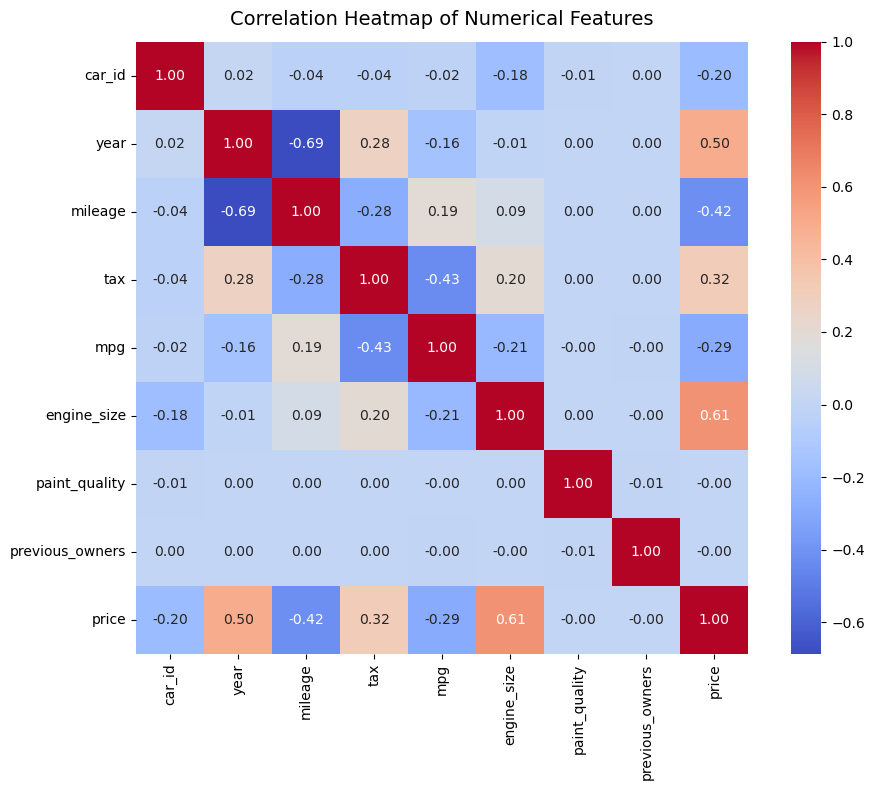

In [883]:
#only numeric columns for correlation
numeric_df = df.select_dtypes(include=['int64', 'float64'])
# Computing correlation matrix ---
corr_matrix = numeric_df.corr()
# Plotting correlation heatmap 
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar=True)
plt.title("Correlation Heatmap of Numerical Features", fontsize=14, pad=12)
plt.tight_layout()
plt.show()
target = 'price' 
# to identify top correlated features with the target
top_corr_features = corr_matrix[target].abs().sort_values(ascending=False).head(5).index.tolist()

#### **Target Correlation (Key Predictors)**
- engine_size, year, mileage, tax, and mpg have the strongest relationship with price.
-  **These should be primary input features for model training.**
#### **Low/No Correlation Features**
-  **paint_quality, previous_owners, car_id add noise and don’t help predict price.**

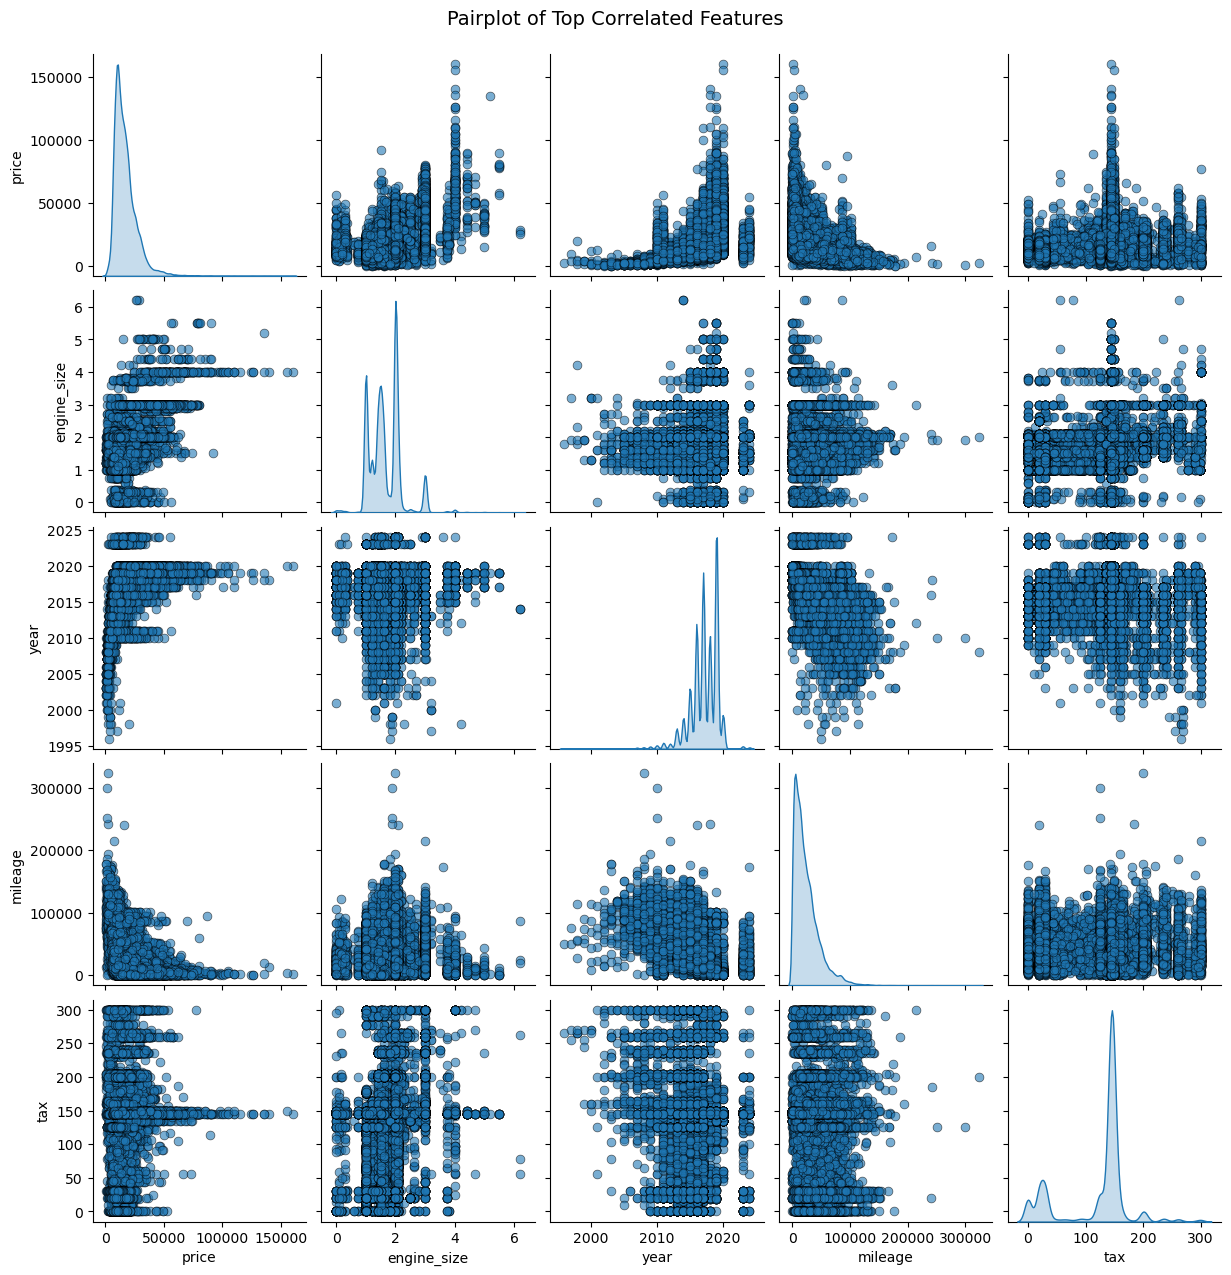

In [884]:
# a smaller DataFrame for pairplot
pairplot_df = df[top_corr_features]
# Plot pairplot
sns.pairplot(pairplot_df, diag_kind="kde", plot_kws={'alpha':0.6, 's':40, 'edgecolor':'k'})
plt.suptitle("Pairplot of Top Correlated Features", y=1.02, fontsize=14)
plt.show()

#### **Price vs Year**
- Clear positive relationship: newer cars (2020+) have higher prices.
✅ Strong predictor for price — probably among your top correlated features.
#### **Price vs Mileage**
-  Negative correlation — as expected, higher mileage = lower price.
✅ Another strong and intuitive predictor.
#### **Price vs Engine Size**
- Generally positive, but nonlinear: price increases up to ~2.5L, then scatters.
Suggests larger engines don’t always mean higher price — some luxury outliers remain.
#### **Price vs MPG**
-  Negative trend — higher MPG (fuel efficiency) often means cheaper cars.
✅ Makes sense: economy cars are more efficient but lower-priced.